## Problema 2

### Funções de suporte e principais definições

    Resultados gráficos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg

In [2]:
u = lambda x,y: np.cos(x) * np.sin(y)
f = lambda x,y: -2 * np.cos(x) * np.sin(y)

    item (a)

In [3]:
def verify() -> bool:
    """
    Verifies whether the function f(x, y) corresponds to the expression -Δu(x, y)
    by comparing it to a known right-hand side over a small 5x5 grid.

    Returns:
        bool: True if the expression matches at all points, False otherwise.
    """
    X = np.linspace(0, 1, 5)
    Y = np.linspace(0, 1, 5)
    for x in X:
        for y in Y:
            left = f(x, y)  # left-hand side of the equation
            right = -2 * np.cos(x) * np.sin(y)  # right-hand side of the equation
            
            if not np.isclose(left, right):
                print(f"Error: at (x={x}, y={y}), left = {left}, right = {right}")
                return False
    
    print("The solution u(x, y) satisfies the equation with the source term f(x, y)!")
    return True


In [4]:
print("Validating item (a)")
verify()

Validating item (a)
The solution u(x, y) satisfies the equation with the source term f(x, y)!


True

    item (b)

In [5]:
def poisson_system(N: int, f: float, g: float):
    """
    Constructs the linear system A·u = b resulting from the finite difference
    discretization of the Poisson equation -Δu = f on a unit square domain,
    with Dirichlet boundary conditions given by the function g.

    Parameters:
        N (int): Number of subdivisions in each spatial direction (grid spacing h = 1/N).
        f (function): Function f(x, y), representing the source term -Δu.
        g (function): Function g(x, y), representing Dirichlet boundary values.

    Returns:
        A: Sparse matrix representing the Laplace operator.
        b: Right-hand side vector including source term and boundary conditions.
    """
    h = 1 / N
    n = (N - 1) ** 2 
    diagonals = [-1, -1, 4, -1, -1]
    offsets = [-N + 1, -1, 0, 1, N - 1]  # check diagonal offsets

    # Matrix A
    A: csc_array = diags(diagonals=diagonals, offsets=offsets, shape=(n, n)).tocsc()

    # Vector b (equation terms and boundary conditions)
    b = np.zeros(n)

    # Fill b with f (interior points)
    for k in range(1, N):
        for j in range(1, N):
            i = (k - 1) * (N - 1) + (j - 1)  # lexicographic order
            x, y = k * h, j * h
            b[i] = h ** 2 * f(x, y)

            # Borders (left -> right) & (bottom -> top): boundary conditions
            if k == 1:
                b[i] -= g(0, y)  # left border
            if k == N - 1:
                b[i] -= g(1, y)  # right border
            if j == 1:
                b[i] -= g(x, 0)  # bottom border
            if j == N - 1:
                b[i] -= g(x, 1)  # top border

    return A, b


In [6]:
def error_function(N, exact, numeric) -> pd.DataFrame:
    """
    Computes the absolute error between the exact and numerical solutions 
    of the Poisson equation on a uniform grid, and returns it as a DataFrame.

    Parameters:
        N (int): Number of subdivisions (grid has (N+1) x (N+1) points).
        exact (function): Function that computes the exact solution u(x, y).
        numeric (np.ndarray): Flattened array with the numerical solution at interior points.

    Returns:
        pd.DataFrame: Table of absolute errors at each grid point, 
                      indexed by x and labeled by y.
    """
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1)
    X, Y = np.meshgrid(x, y)

    # Exact solution at grid points
    U_exact = exact(X, Y)

    # Insert numerical solution into interior grid points
    U_numeric = np.zeros((N+1, N+1))
    U_numeric[1:N, 1:N] = numeric.reshape((N-1, N-1))

    # Compute absolute error
    errors = np.abs(U_exact - U_numeric)
    df = pd.DataFrame(errors, 
                      columns=[f"Error y={i/(N+1):.2f}" for i in range(N+1)],
                      index=[f"x={i/(N+1):.2f}" for i in range(N+1)])
    
    return df


In [7]:
def plot_solutions(N, exact, numeric):
    """
    Plots side-by-side contour plots of the exact and numerical solutions 
    of the Poisson equation on a uniform (N+1) x (N+1) grid.

    Parameters:
        N (int): Number of subdivisions in each direction.
        exact (function): Function that computes the exact solution u(x, y).
        numeric (np.ndarray): Flattened array with the numerical solution at interior points.
    """
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1)
    X, Y = np.meshgrid(x, y)

    # Exact solution
    U_exact = exact(X, Y)

    # Insert numerical solution into interior grid points
    U_numeric = np.zeros((N+1, N+1))
    U_numeric[1:N, 1:N] = numeric.reshape((N-1, N-1))

    # Plot exact solution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, U_exact, cmap='plasma')
    plt.colorbar()
    plt.title('Exact Solution')

    # Plot numerical solution
    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, U_numeric, cmap='plasma')
    plt.colorbar()
    plt.title('Numerical Solution')

    plt.show()


In [8]:
def solve_system(N, f, u):
    """
    Solves the Poisson equation -Δu = f on a unit square using the finite
    difference method with Dirichlet boundary conditions, then visualizes and
    evaluates the result.

    Steps:
        (i) Builds the linear system A·u = b using the source function f and boundary condition g = u.
        (ii) Solves the linear system using a sparse solver.
        (iii) Plots both exact and numerical solutions for comparison.
        (iv) Prints a DataFrame with the absolute error at each grid point.

    Parameters:
        N (int): Number of subdivisions in each spatial direction.
        f (function): Function f(x, y) = -Δu(x, y), the right-hand side of the equation.
        u (function): Exact solution u(x, y), also used to define Dirichlet boundary conditions.
    """
    g = lambda x, y: u(x, y)

    A, b = poisson_system(N, f, g)        # (i)
    numeric = linalg.spsolve(A, b)        # (ii)
    plot_solutions(N, u, numeric)         # (iii)
    print(error_function(N, u, numeric))  # (iv)


========== Simulations ==========

***** N = 50 *****



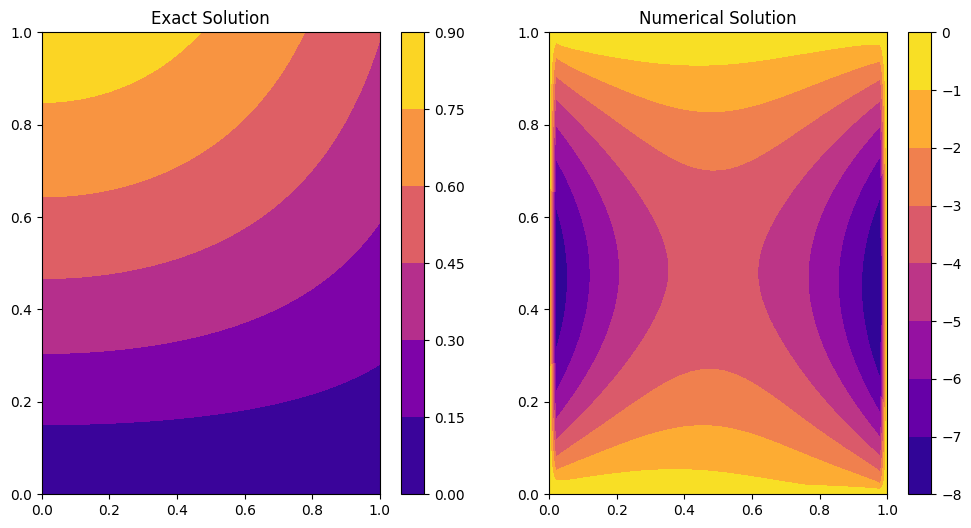

        Error y=0.00  Error y=0.02  Error y=0.04  Error y=0.06  Error y=0.08  \
x=0.00      0.000000      0.000000      0.000000      0.000000      0.000000   
x=0.02      0.019999      0.578508      0.684973      0.683980      0.660639   
x=0.04      0.039989      1.589030      1.437367      1.330280      1.242307   
x=0.06      0.059964      2.400820      2.145119      1.957388      1.809556   
x=0.08      0.079915      3.089297      2.784822      2.544500      2.349732   
x=0.10      0.099833      3.690813      3.360276      3.085948      2.856388   
x=0.12      0.119712      4.225322      3.879411      3.582500      3.327469   
x=0.14      0.139543      4.705026      4.349416      4.037030      3.763262   
x=0.16      0.159318      5.138025      4.776055      4.452783      4.165096   
x=0.18      0.179030      5.530035      5.163839      4.832778      4.534656   
x=0.20      0.198669      5.885279      5.516312      5.179643      4.873659   
x=0.22      0.218230      6.206984      

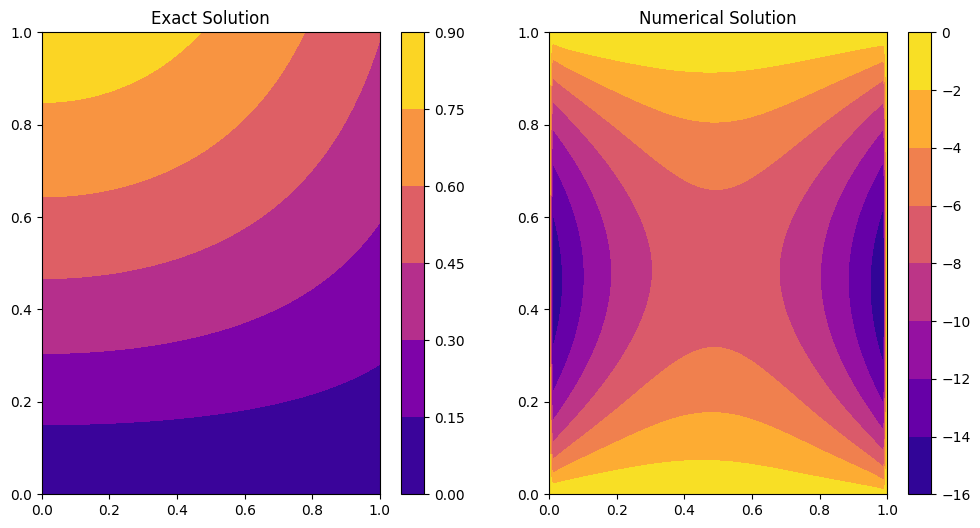

        Error y=0.00  Error y=0.01  Error y=0.02  Error y=0.03  Error y=0.04  \
x=0.00      0.000000      0.000000      0.000000      0.000000      0.000000   
x=0.01      0.010000      0.659973      0.792970      0.797210      0.770953   
x=0.02      0.019999      1.826916      1.694693      1.594913      1.506606   
x=0.03      0.029996      2.808349      2.563966      2.381132      2.232565   
x=0.04      0.039989      3.670482      3.371679      3.133073      2.935849   
...              ...           ...           ...           ...           ...   
x=0.95      0.819192      3.914551      3.660726      3.448507      3.271873   
x=0.96      0.824886      3.315070      3.062911      2.866516      2.712433   
x=0.97      0.830497      2.653385      2.409165      2.242047      2.122267   
x=0.98      0.836026      1.881082      1.678148      1.570069      1.502613   
x=0.99      0.841471      0.841429      0.841303      0.841092      0.840798   

        Error y=0.05  Error y=0.06  Err

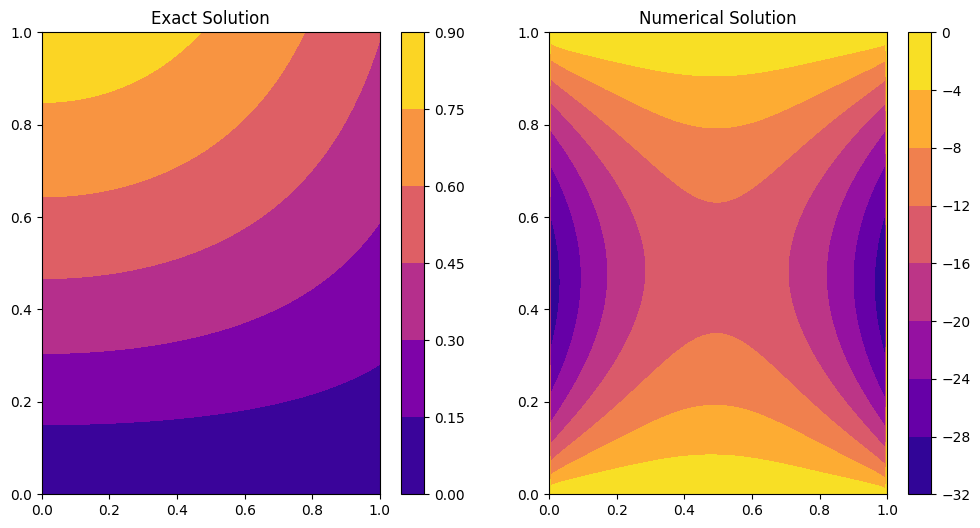

        Error y=0.00  Error y=0.00  Error y=0.01  Error y=0.01  Error y=0.02  \
x=0.00      0.000000      0.000000      0.000000      0.000000      0.000000   
x=0.00      0.005000      0.752183      0.917236      0.932284      0.908831   
x=0.01      0.010000      2.081495      1.974477      1.888068      1.805867   
x=0.01      0.014999      3.238401      3.011107      2.839644      2.697470   
x=0.02      0.019999      4.279122      3.991903      3.761930      3.570084   
...              ...           ...           ...           ...           ...   
x=0.98      0.830497      4.350778      4.096135      3.883569      3.707053   
x=0.98      0.833272      3.647422      3.391490      3.192660      3.037151   
x=0.99      0.836026      2.880918      2.629700      2.458386      2.336013   
x=0.99      0.838759      2.000148      1.787963      1.675131      1.604651   
x=1.00      0.841471      0.841460      0.841429      0.841376      0.841303   

        Error y=0.02  Error y=0.03  Err

In [9]:
print(f"{'='*10} Simulations {'='*10}\n")
for N in [50, 100, 200]:
    print(f"{'*'*5} N = {N} {'*'*5}\n")
    solve_system(N, f, u)
